Kanishk Navale - 3437531

Deep Learning in Language & Speech Recognition

Project: *Speech Emotion Recognition*

In [22]:
# Math Computations
import numpy as np
import random
from sklearn.utils import shuffle
import gc

# Reading the datasets
import json
import pandas as pd

# Plotting the data
import matplotlib.pyplot as plt

# Data Prep. for model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter

# Machine Learning Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, LSTM, Reshape, Flatten, ActivityRegularization, GRU
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2, l1, l1_l2

In [24]:
# Reading the 'train.json' file
dir_train = 'dataset/train.json'

def read_train_data(loc_dev):
    valence = []
    activation = []
    features = []
    data = open(loc_dev, 'r')
    data = json.load(data)
    for i in data:
        valence.append(data[str(i)]['valence'])
        activation.append(data[str(i)]['activation'])
        features.append(np.matrix(data[str(i)]['features']))
    return valence, activation, features


train_valence, train_activation, train_features = read_train_data(dir_train)

In [25]:
# Create Classes from "activation" and "valence"
classes = []

for i in range(len(train_valence)):
    if (train_valence[i]==0 and train_activation[i]==0):
        classes.append(np.array([1,0,0,0]))
    if (train_valence[i]==1 and train_activation[i]==0):
        classes.append(np.array([0,1,0,0]))
    if (train_valence[i]==0 and train_activation[i]==1):
        classes.append(np.array([0,0,1,0]))
    if (train_valence[i]==1 and train_activation[i]==1):
        classes.append(np.array([0,0,0,1]))

In [26]:
# Check the max. dimension of the features
def max_dim(feature_list):
    max_amp = max_len = 0
    for i in range(len(feature_list)):
        if max_amp < feature_list[i].shape[0]:
            max_amp = feature_list[i].shape[0]
        if max_len < feature_list[i].shape[1]:
            max_len = feature_list[i].shape[1]
    return max_amp, max_len


input_shape = max_dim(train_features)
print (f'Feature input dim. for NN: {input_shape}')

Feature input dim. for NN: (1707, 26)


In [28]:
# Rescale the features to the input shape
def scale_features(feature):
        
    # Compute the top and bottom size
    top =  int(np.floor(input_shape[0] - feature.shape[0])/2)
    bottom = int(np.ceil(input_shape[0] - feature.shape[0])/2)

    # Dimension Check
    if (top+bottom+feature.shape[0] != input_shape[0]): bottom += 1
    assert top+bottom+feature.shape[0] == input_shape[0]

    # Padding with zeros
    return np.pad(feature, ((top,bottom),(0,0)), 'constant')

In [29]:
# Creating train & validation data splits
train_X, val_X, train_y, val_y = train_test_split(train_features, classes, test_size=0.2, shuffle=False)

In [30]:
# Scaling the Features
train_X = list(map(scale_features,train_X))
val_X = list(map(scale_features,val_X))

In [31]:
# Convert the lists to tensor
train_X, train_y = np.array(train_X), np.matrix(train_y) 
val_X, val_y = np.array(val_X), np.matrix(val_y)

In [32]:
# Defining the DNN model
def build_model(input_shape):
    
    # *** Sequential Model ****
    model = Sequential()
    
    model.add(Input(shape=input_shape))

    # Reshape the features
    model.add(Reshape((-1, input_shape[1], 1)))
     
    # Joint Feature Extraction from CNN 
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))
    
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(AveragePooling2D((2, 2), strides=(2, 2), padding='valid'))
    
    model.add(Reshape((-1,64)))
              
    # Structural Feature Extraction from LSTM
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    
    #Batch Normalization
    model.add(BatchNormalization())
    
    # Dense Layers
    model.add(Dense(32, use_bias=True, kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Activation('selu'))
    
    # Activation Layer
    model.add(Dense(4, use_bias=True, kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.01)))
    model.add(Activation('softmax'))

    # compile model
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
    model.compile(optimizer=Nadam(learning_rate=1e-4), loss=loss, metrics=['categorical_accuracy'])
    model.summary()
    
    return model

model = build_model((train_X.shape[1],train_X.shape[2]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1707, 26, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1705, 24, 8)       80        
_________________________________________________________________
average_pooling2d_3 (Average (None, 852, 11, 8)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 850, 9, 32)        2336      
_________________________________________________________________
average_pooling2d_4 (Average (None, 424, 4, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 423, 3, 64)        8256      
_________________________________________________________________
average_pooling2d_5 (Average (None, 211, 1, 64)       

In [33]:
# Detect GPU for accelerating the computation
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) !=0:
    device = '/gpu:0'
else:
    device = '/cpu:0'
    
print (f'Computation Device: {device}')

Computation Device: /gpu:0


In [34]:
# Definition for training the Neural Model
def train(filename, model, epochs, batch_size, train_X, val_X, train_y, val_y):

    checkpoint = ModelCheckpoint(filename, monitor='val_categorical_accuracy',mode='max', save_best_only=True, verbose=1)
    
    tf.debugging.set_log_device_placement(True)
    
    with tf.device(device):
        print(f'Training on the device: {device}\n')
        history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X,val_y), callbacks= [checkpoint])
    return history

       
# Model training
EPOCHS = 600
BATCH_SIZE = 8

model_training = train('model.h5', model, EPOCHS, BATCH_SIZE, train_X, val_X, train_y, val_y)

Training on the device: /gpu:0

Epoch 1/600
546/546 [==============================] - ETA: 0s - loss: 1.7256 - categorical_accuracy: 0.4093
Epoch 00001: val_categorical_accuracy improved from -inf to 0.40293, saving model to model.h5
546/546 [==============================] - 14s 26ms/step - loss: 1.7256 - categorical_accuracy: 0.4093 - val_loss: 1.6182 - val_categorical_accuracy: 0.4029
Epoch 2/600
546/546 [==============================] - ETA: 0s - loss: 1.5551 - categorical_accuracy: 0.4146
Epoch 00002: val_categorical_accuracy did not improve from 0.40293
546/546 [==============================] - 14s 25ms/step - loss: 1.5551 - categorical_accuracy: 0.4146 - val_loss: 1.5827 - val_categorical_accuracy: 0.2445
Epoch 3/600
545/546 [============================>.] - ETA: 0s - loss: 1.4380 - categorical_accuracy: 0.4259
Epoch 00003: val_categorical_accuracy did not improve from 0.40293
546/546 [==============================] - 13s 24ms/step - loss: 1.4379 - categorical_accuracy: 0.4

545/546 [============================>.] - ETA: 0s - loss: 1.2628 - categorical_accuracy: 0.4599
Epoch 00025: val_categorical_accuracy did not improve from 0.46062
546/546 [==============================] - 13s 24ms/step - loss: 1.2628 - categorical_accuracy: 0.4599 - val_loss: 1.3789 - val_categorical_accuracy: 0.3315
Epoch 26/600
546/546 [==============================] - ETA: 0s - loss: 1.2520 - categorical_accuracy: 0.4663
Epoch 00026: val_categorical_accuracy did not improve from 0.46062
546/546 [==============================] - 13s 24ms/step - loss: 1.2520 - categorical_accuracy: 0.4663 - val_loss: 1.3159 - val_categorical_accuracy: 0.3755
Epoch 27/600
546/546 [==============================] - ETA: 0s - loss: 1.2505 - categorical_accuracy: 0.4711
Epoch 00027: val_categorical_accuracy did not improve from 0.46062
546/546 [==============================] - 13s 25ms/step - loss: 1.2505 - categorical_accuracy: 0.4711 - val_loss: 1.4039 - val_categorical_accuracy: 0.4185
Epoch 28/60

Epoch 50/600
546/546 [==============================] - ETA: 0s - loss: 1.2292 - categorical_accuracy: 0.4837
Epoch 00050: val_categorical_accuracy did not improve from 0.50000
546/546 [==============================] - 13s 24ms/step - loss: 1.2292 - categorical_accuracy: 0.4837 - val_loss: 1.2673 - val_categorical_accuracy: 0.4405
Epoch 51/600
546/546 [==============================] - ETA: 0s - loss: 1.2269 - categorical_accuracy: 0.4821
Epoch 00051: val_categorical_accuracy did not improve from 0.50000
546/546 [==============================] - 13s 24ms/step - loss: 1.2269 - categorical_accuracy: 0.4821 - val_loss: 1.2344 - val_categorical_accuracy: 0.4432
Epoch 52/600
545/546 [============================>.] - ETA: 0s - loss: 1.2286 - categorical_accuracy: 0.4901
Epoch 00052: val_categorical_accuracy did not improve from 0.50000
546/546 [==============================] - 13s 24ms/step - loss: 1.2284 - categorical_accuracy: 0.4902 - val_loss: 1.2321 - val_categorical_accuracy: 0.482

Epoch 75/600
544/546 [============================>.] - ETA: 0s - loss: 1.2343 - categorical_accuracy: 0.4878
Epoch 00075: val_categorical_accuracy did not improve from 0.50916
546/546 [==============================] - 13s 23ms/step - loss: 1.2345 - categorical_accuracy: 0.4872 - val_loss: 1.4903 - val_categorical_accuracy: 0.2976
Epoch 76/600
544/546 [============================>.] - ETA: 0s - loss: 1.2207 - categorical_accuracy: 0.4901
Epoch 00076: val_categorical_accuracy did not improve from 0.50916
546/546 [==============================] - 13s 24ms/step - loss: 1.2212 - categorical_accuracy: 0.4892 - val_loss: 1.2438 - val_categorical_accuracy: 0.4753
Epoch 77/600
544/546 [============================>.] - ETA: 0s - loss: 1.2192 - categorical_accuracy: 0.4887
Epoch 00077: val_categorical_accuracy did not improve from 0.50916
546/546 [==============================] - 13s 24ms/step - loss: 1.2191 - categorical_accuracy: 0.4890 - val_loss: 1.2821 - val_categorical_accuracy: 0.447

Epoch 100/600
544/546 [============================>.] - ETA: 0s - loss: 1.2115 - categorical_accuracy: 0.5106
Epoch 00100: val_categorical_accuracy did not improve from 0.50916
546/546 [==============================] - 13s 25ms/step - loss: 1.2116 - categorical_accuracy: 0.5103 - val_loss: 1.3788 - val_categorical_accuracy: 0.4634
Epoch 101/600
544/546 [============================>.] - ETA: 0s - loss: 1.2137 - categorical_accuracy: 0.5034
Epoch 00101: val_categorical_accuracy did not improve from 0.50916
546/546 [==============================] - 13s 24ms/step - loss: 1.2137 - categorical_accuracy: 0.5034 - val_loss: 1.2190 - val_categorical_accuracy: 0.5018
Epoch 102/600
546/546 [==============================] - ETA: 0s - loss: 1.2158 - categorical_accuracy: 0.5082
Epoch 00102: val_categorical_accuracy did not improve from 0.50916
546/546 [==============================] - 13s 24ms/step - loss: 1.2158 - categorical_accuracy: 0.5082 - val_loss: 1.2210 - val_categorical_accuracy: 0.

545/546 [============================>.] - ETA: 0s - loss: 1.2138 - categorical_accuracy: 0.5092
Epoch 00124: val_categorical_accuracy did not improve from 0.51465
546/546 [==============================] - 13s 24ms/step - loss: 1.2144 - categorical_accuracy: 0.5085 - val_loss: 1.2119 - val_categorical_accuracy: 0.5137
Epoch 125/600
545/546 [============================>.] - ETA: 0s - loss: 1.2078 - categorical_accuracy: 0.5064
Epoch 00125: val_categorical_accuracy did not improve from 0.51465
546/546 [==============================] - 13s 25ms/step - loss: 1.2078 - categorical_accuracy: 0.5066 - val_loss: 1.2305 - val_categorical_accuracy: 0.4799
Epoch 126/600
544/546 [============================>.] - ETA: 0s - loss: 1.2080 - categorical_accuracy: 0.5216
Epoch 00126: val_categorical_accuracy did not improve from 0.51465
546/546 [==============================] - 13s 24ms/step - loss: 1.2078 - categorical_accuracy: 0.5215 - val_loss: 1.2366 - val_categorical_accuracy: 0.4679
Epoch 127

545/546 [============================>.] - ETA: 0s - loss: 1.2036 - categorical_accuracy: 0.5183
Epoch 00148: val_categorical_accuracy did not improve from 0.51740
546/546 [==============================] - 13s 23ms/step - loss: 1.2035 - categorical_accuracy: 0.5183 - val_loss: 1.2639 - val_categorical_accuracy: 0.4432
Epoch 149/600
544/546 [============================>.] - ETA: 0s - loss: 1.1952 - categorical_accuracy: 0.5303
Epoch 00149: val_categorical_accuracy did not improve from 0.51740
546/546 [==============================] - 13s 24ms/step - loss: 1.1958 - categorical_accuracy: 0.5298 - val_loss: 1.4389 - val_categorical_accuracy: 0.4588
Epoch 150/600
546/546 [==============================] - ETA: 0s - loss: 1.1988 - categorical_accuracy: 0.5293
Epoch 00150: val_categorical_accuracy did not improve from 0.51740
546/546 [==============================] - 13s 24ms/step - loss: 1.1988 - categorical_accuracy: 0.5293 - val_loss: 1.3156 - val_categorical_accuracy: 0.4524
Epoch 151

Epoch 173/600
544/546 [============================>.] - ETA: 0s - loss: 1.1893 - categorical_accuracy: 0.5432
Epoch 00173: val_categorical_accuracy did not improve from 0.54029
546/546 [==============================] - 13s 24ms/step - loss: 1.1893 - categorical_accuracy: 0.5428 - val_loss: 1.2107 - val_categorical_accuracy: 0.5201
Epoch 174/600
545/546 [============================>.] - ETA: 0s - loss: 1.1931 - categorical_accuracy: 0.5305
Epoch 00174: val_categorical_accuracy did not improve from 0.54029
546/546 [==============================] - 13s 23ms/step - loss: 1.1928 - categorical_accuracy: 0.5309 - val_loss: 1.2217 - val_categorical_accuracy: 0.4954
Epoch 175/600
544/546 [============================>.] - ETA: 0s - loss: 1.1890 - categorical_accuracy: 0.5443
Epoch 00175: val_categorical_accuracy did not improve from 0.54029
546/546 [==============================] - 13s 24ms/step - loss: 1.1885 - categorical_accuracy: 0.5449 - val_loss: 1.2359 - val_categorical_accuracy: 0.

Epoch 198/600
545/546 [============================>.] - ETA: 0s - loss: 1.1824 - categorical_accuracy: 0.5505
Epoch 00198: val_categorical_accuracy did not improve from 0.54304
546/546 [==============================] - 13s 25ms/step - loss: 1.1824 - categorical_accuracy: 0.5504 - val_loss: 1.2988 - val_categorical_accuracy: 0.4716
Epoch 199/600
545/546 [============================>.] - ETA: 0s - loss: 1.1817 - categorical_accuracy: 0.5550
Epoch 00199: val_categorical_accuracy did not improve from 0.54304
546/546 [==============================] - 13s 23ms/step - loss: 1.1818 - categorical_accuracy: 0.5550 - val_loss: 1.2720 - val_categorical_accuracy: 0.5293
Epoch 200/600
545/546 [============================>.] - ETA: 0s - loss: 1.1780 - categorical_accuracy: 0.5644
Epoch 00200: val_categorical_accuracy did not improve from 0.54304
546/546 [==============================] - 13s 24ms/step - loss: 1.1778 - categorical_accuracy: 0.5646 - val_loss: 1.2654 - val_categorical_accuracy: 0.

Epoch 223/600
546/546 [==============================] - ETA: 0s - loss: 1.1683 - categorical_accuracy: 0.5712
Epoch 00223: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 24ms/step - loss: 1.1683 - categorical_accuracy: 0.5712 - val_loss: 1.2208 - val_categorical_accuracy: 0.5119
Epoch 224/600
545/546 [============================>.] - ETA: 0s - loss: 1.1673 - categorical_accuracy: 0.5764
Epoch 00224: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 24ms/step - loss: 1.1671 - categorical_accuracy: 0.5763 - val_loss: 1.2245 - val_categorical_accuracy: 0.5412
Epoch 225/600
546/546 [==============================] - ETA: 0s - loss: 1.1702 - categorical_accuracy: 0.5669
Epoch 00225: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 25ms/step - loss: 1.1702 - categorical_accuracy: 0.5669 - val_loss: 1.2253 - val_categorical_accuracy: 0.

Epoch 248/600
544/546 [============================>.] - ETA: 0s - loss: 1.1594 - categorical_accuracy: 0.5823
Epoch 00248: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 24ms/step - loss: 1.1596 - categorical_accuracy: 0.5815 - val_loss: 1.2528 - val_categorical_accuracy: 0.4496
Epoch 249/600
546/546 [==============================] - ETA: 0s - loss: 1.1511 - categorical_accuracy: 0.5902
Epoch 00249: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 14s 25ms/step - loss: 1.1511 - categorical_accuracy: 0.5902 - val_loss: 1.4308 - val_categorical_accuracy: 0.3269
Epoch 250/600
545/546 [============================>.] - ETA: 0s - loss: 1.1635 - categorical_accuracy: 0.5846
Epoch 00250: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 24ms/step - loss: 1.1635 - categorical_accuracy: 0.5843 - val_loss: 1.2222 - val_categorical_accuracy: 0.

Epoch 273/600
544/546 [============================>.] - ETA: 0s - loss: 1.1402 - categorical_accuracy: 0.6032
Epoch 00273: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 24ms/step - loss: 1.1396 - categorical_accuracy: 0.6040 - val_loss: 1.2278 - val_categorical_accuracy: 0.5211
Epoch 274/600
544/546 [============================>.] - ETA: 0s - loss: 1.1331 - categorical_accuracy: 0.6172
Epoch 00274: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 14s 25ms/step - loss: 1.1331 - categorical_accuracy: 0.6173 - val_loss: 1.2523 - val_categorical_accuracy: 0.5055
Epoch 275/600
545/546 [============================>.] - ETA: 0s - loss: 1.1335 - categorical_accuracy: 0.6099
Epoch 00275: val_categorical_accuracy did not improve from 0.54670
546/546 [==============================] - 13s 24ms/step - loss: 1.1336 - categorical_accuracy: 0.6097 - val_loss: 1.2429 - val_categorical_accuracy: 0.

Epoch 298/600
544/546 [============================>.] - ETA: 0s - loss: 1.1003 - categorical_accuracy: 0.6452
Epoch 00298: val_categorical_accuracy did not improve from 0.54853
546/546 [==============================] - 13s 24ms/step - loss: 1.1006 - categorical_accuracy: 0.6450 - val_loss: 1.2443 - val_categorical_accuracy: 0.5293
Epoch 299/600
544/546 [============================>.] - ETA: 0s - loss: 1.1013 - categorical_accuracy: 0.6344
Epoch 00299: val_categorical_accuracy did not improve from 0.54853
546/546 [==============================] - 13s 24ms/step - loss: 1.1010 - categorical_accuracy: 0.6349 - val_loss: 1.2454 - val_categorical_accuracy: 0.5403
Epoch 300/600
546/546 [==============================] - ETA: 0s - loss: 1.0852 - categorical_accuracy: 0.6567
Epoch 00300: val_categorical_accuracy did not improve from 0.54853
546/546 [==============================] - 14s 25ms/step - loss: 1.0852 - categorical_accuracy: 0.6567 - val_loss: 1.2631 - val_categorical_accuracy: 0.

Epoch 323/600
545/546 [============================>.] - ETA: 0s - loss: 1.0632 - categorical_accuracy: 0.6768
Epoch 00323: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 1.0631 - categorical_accuracy: 0.6768 - val_loss: 1.3182 - val_categorical_accuracy: 0.5037
Epoch 324/600
546/546 [==============================] - ETA: 0s - loss: 1.0594 - categorical_accuracy: 0.6878
Epoch 00324: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 1.0594 - categorical_accuracy: 0.6878 - val_loss: 1.2663 - val_categorical_accuracy: 0.5293
Epoch 325/600
544/546 [============================>.] - ETA: 0s - loss: 1.0502 - categorical_accuracy: 0.6916
Epoch 00325: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 1.0501 - categorical_accuracy: 0.6922 - val_loss: 1.2774 - val_categorical_accuracy: 0.

Epoch 348/600
544/546 [============================>.] - ETA: 0s - loss: 1.0197 - categorical_accuracy: 0.7266
Epoch 00348: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 1.0200 - categorical_accuracy: 0.7265 - val_loss: 1.3008 - val_categorical_accuracy: 0.5201
Epoch 349/600
546/546 [==============================] - ETA: 0s - loss: 1.0133 - categorical_accuracy: 0.7327
Epoch 00349: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 1.0133 - categorical_accuracy: 0.7327 - val_loss: 1.3199 - val_categorical_accuracy: 0.5009
Epoch 350/600
546/546 [==============================] - ETA: 0s - loss: 1.0204 - categorical_accuracy: 0.7231
Epoch 00350: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 1.0204 - categorical_accuracy: 0.7231 - val_loss: 1.3167 - val_categorical_accuracy: 0.

Epoch 373/600
544/546 [============================>.] - ETA: 0s - loss: 0.9910 - categorical_accuracy: 0.7532
Epoch 00373: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9910 - categorical_accuracy: 0.7531 - val_loss: 1.2888 - val_categorical_accuracy: 0.5385
Epoch 374/600
545/546 [============================>.] - ETA: 0s - loss: 0.9766 - categorical_accuracy: 0.7644
Epoch 00374: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 0.9766 - categorical_accuracy: 0.7643 - val_loss: 1.3621 - val_categorical_accuracy: 0.5375
Epoch 375/600
546/546 [==============================] - ETA: 0s - loss: 0.9993 - categorical_accuracy: 0.7435
Epoch 00375: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9993 - categorical_accuracy: 0.7435 - val_loss: 1.3654 - val_categorical_accuracy: 0.

Epoch 398/600
545/546 [============================>.] - ETA: 0s - loss: 0.9676 - categorical_accuracy: 0.7741
Epoch 00398: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9680 - categorical_accuracy: 0.7739 - val_loss: 1.3522 - val_categorical_accuracy: 0.5275
Epoch 399/600
545/546 [============================>.] - ETA: 0s - loss: 0.9426 - categorical_accuracy: 0.7959
Epoch 00399: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9423 - categorical_accuracy: 0.7962 - val_loss: 1.4242 - val_categorical_accuracy: 0.5183
Epoch 400/600
544/546 [============================>.] - ETA: 0s - loss: 0.9653 - categorical_accuracy: 0.7819
Epoch 00400: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9645 - categorical_accuracy: 0.7826 - val_loss: 1.4154 - val_categorical_accuracy: 0.

Epoch 423/600
544/546 [============================>.] - ETA: 0s - loss: 1.0973 - categorical_accuracy: 0.6668
Epoch 00423: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 1.0971 - categorical_accuracy: 0.6672 - val_loss: 1.4054 - val_categorical_accuracy: 0.5073
Epoch 424/600
546/546 [==============================] - ETA: 0s - loss: 0.9311 - categorical_accuracy: 0.8053
Epoch 00424: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9311 - categorical_accuracy: 0.8053 - val_loss: 1.4173 - val_categorical_accuracy: 0.5064
Epoch 425/600
545/546 [============================>.] - ETA: 0s - loss: 0.9479 - categorical_accuracy: 0.8016
Epoch 00425: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 25ms/step - loss: 0.9475 - categorical_accuracy: 0.8019 - val_loss: 1.4626 - val_categorical_accuracy: 0.

Epoch 448/600
544/546 [============================>.] - ETA: 0s - loss: 0.9787 - categorical_accuracy: 0.7732
Epoch 00448: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9783 - categorical_accuracy: 0.7737 - val_loss: 1.3855 - val_categorical_accuracy: 0.5357
Epoch 449/600
546/546 [==============================] - ETA: 0s - loss: 0.8809 - categorical_accuracy: 0.8381
Epoch 00449: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8809 - categorical_accuracy: 0.8381 - val_loss: 1.5241 - val_categorical_accuracy: 0.4963
Epoch 450/600
545/546 [============================>.] - ETA: 0s - loss: 0.8949 - categorical_accuracy: 0.8342
Epoch 00450: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8953 - categorical_accuracy: 0.8339 - val_loss: 1.4791 - val_categorical_accuracy: 0.

Epoch 473/600
545/546 [============================>.] - ETA: 0s - loss: 0.9009 - categorical_accuracy: 0.8337
Epoch 00473: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 0.9006 - categorical_accuracy: 0.8339 - val_loss: 1.5013 - val_categorical_accuracy: 0.5165
Epoch 474/600
545/546 [============================>.] - ETA: 0s - loss: 0.8630 - categorical_accuracy: 0.8573
Epoch 00474: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8627 - categorical_accuracy: 0.8575 - val_loss: 1.4764 - val_categorical_accuracy: 0.5192
Epoch 475/600
546/546 [==============================] - ETA: 0s - loss: 0.8907 - categorical_accuracy: 0.8321
Epoch 00475: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8907 - categorical_accuracy: 0.8321 - val_loss: 1.4623 - val_categorical_accuracy: 0.

Epoch 498/600
546/546 [==============================] - ETA: 0s - loss: 0.8202 - categorical_accuracy: 0.8850
Epoch 00498: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8202 - categorical_accuracy: 0.8850 - val_loss: 1.5008 - val_categorical_accuracy: 0.5302
Epoch 499/600
546/546 [==============================] - ETA: 0s - loss: 0.8985 - categorical_accuracy: 0.8211
Epoch 00499: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 25ms/step - loss: 0.8985 - categorical_accuracy: 0.8211 - val_loss: 1.5206 - val_categorical_accuracy: 0.4954
Epoch 500/600
545/546 [============================>.] - ETA: 0s - loss: 0.8480 - categorical_accuracy: 0.8686
Epoch 00500: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8480 - categorical_accuracy: 0.8685 - val_loss: 1.5878 - val_categorical_accuracy: 0.

Epoch 523/600
546/546 [==============================] - ETA: 0s - loss: 0.8939 - categorical_accuracy: 0.8369
Epoch 00523: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8939 - categorical_accuracy: 0.8369 - val_loss: 1.5688 - val_categorical_accuracy: 0.4661
Epoch 524/600
546/546 [==============================] - ETA: 0s - loss: 0.9029 - categorical_accuracy: 0.8282
Epoch 00524: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 14s 25ms/step - loss: 0.9029 - categorical_accuracy: 0.8282 - val_loss: 1.5014 - val_categorical_accuracy: 0.5073
Epoch 525/600
546/546 [==============================] - ETA: 0s - loss: 0.8410 - categorical_accuracy: 0.8740
Epoch 00525: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8410 - categorical_accuracy: 0.8740 - val_loss: 1.5387 - val_categorical_accuracy: 0.

Epoch 548/600
545/546 [============================>.] - ETA: 0s - loss: 0.9300 - categorical_accuracy: 0.8037
Epoch 00548: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9300 - categorical_accuracy: 0.8033 - val_loss: 1.5969 - val_categorical_accuracy: 0.4606
Epoch 549/600
546/546 [==============================] - ETA: 0s - loss: 0.8438 - categorical_accuracy: 0.8690
Epoch 00549: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8438 - categorical_accuracy: 0.8690 - val_loss: 1.5495 - val_categorical_accuracy: 0.5000
Epoch 550/600
546/546 [==============================] - ETA: 0s - loss: 0.8289 - categorical_accuracy: 0.8781
Epoch 00550: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 0.8289 - categorical_accuracy: 0.8781 - val_loss: 1.5505 - val_categorical_accuracy: 0.

Epoch 573/600
544/546 [============================>.] - ETA: 0s - loss: 0.8195 - categorical_accuracy: 0.8824
Epoch 00573: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8190 - categorical_accuracy: 0.8827 - val_loss: 1.5254 - val_categorical_accuracy: 0.5183
Epoch 574/600
545/546 [============================>.] - ETA: 0s - loss: 0.9068 - categorical_accuracy: 0.8222
Epoch 00574: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.9066 - categorical_accuracy: 0.8223 - val_loss: 1.4619 - val_categorical_accuracy: 0.5082
Epoch 575/600
545/546 [============================>.] - ETA: 0s - loss: 0.8051 - categorical_accuracy: 0.8968
Epoch 00575: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 0.8056 - categorical_accuracy: 0.8965 - val_loss: 1.5355 - val_categorical_accuracy: 0.

Epoch 598/600
545/546 [============================>.] - ETA: 0s - loss: 0.8036 - categorical_accuracy: 0.8913
Epoch 00598: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 14s 25ms/step - loss: 0.8036 - categorical_accuracy: 0.8912 - val_loss: 1.5580 - val_categorical_accuracy: 0.5183
Epoch 599/600
545/546 [============================>.] - ETA: 0s - loss: 0.9509 - categorical_accuracy: 0.7823
Epoch 00599: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 23ms/step - loss: 0.9511 - categorical_accuracy: 0.7822 - val_loss: 1.3162 - val_categorical_accuracy: 0.4744
Epoch 600/600
544/546 [============================>.] - ETA: 0s - loss: 0.8316 - categorical_accuracy: 0.8778
Epoch 00600: val_categorical_accuracy did not improve from 0.54945
546/546 [==============================] - 13s 24ms/step - loss: 0.8330 - categorical_accuracy: 0.8772 - val_loss: 1.5901 - val_categorical_accuracy: 0.

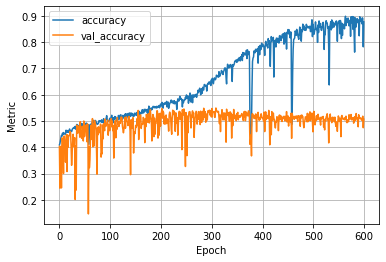

In [35]:
# Plot the training history
def dashboard(log):
    plt.figure()
    plt.plot(log.history["categorical_accuracy"], label="accuracy")
    plt.plot(log.history['val_categorical_accuracy'], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.grid(True)
    plt.legend(loc='best')
 
dashboard(model_training)

In [36]:
# Load the best Model
model = tf.keras.models.load_model('./model.h5')

In [37]:
# Argmax of predictions
def extract_labels(tensor):
    labels = [np.argmax(prediction) for prediction in tensor]
    return labels

35/35 [==============================] - 0s 12ms/step - loss: 1.2784 - categorical_accuracy: 0.5495
Evaluation Score Matrix: 54.95%

              precision    recall  f1-score   support

    Class #0       0.43      0.32      0.37       160
    Class #1       0.33      0.15      0.20       137
    Class #2       0.62      0.76      0.68       440
    Class #3       0.52      0.55      0.53       355

    accuracy                           0.55      1092
   macro avg       0.48      0.44      0.45      1092
weighted avg       0.52      0.55      0.53      1092



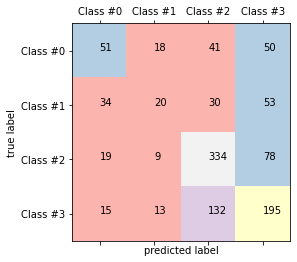

In [38]:
# Evaluate the model again!
score = model.evaluate(val_X, val_y)
print (f'Evaluation Score Matrix: {np.around(score[1]*100, 2)}%\n')

# Predict the 'val_X' for confusion matrix
pred_y = model.predict(val_X)

# Extract the labels
val_y = extract_labels(val_y)
pred_y = extract_labels(pred_y)

# Plot the confusion matrix
cm = confusion_matrix(val_y, pred_y)
fig, ax = plt.subplots(1, 1)
ax.matshow(cm, cmap='Pastel1')
for x in range(cm.shape[0]):
    for y in range(cm.shape[1]):
        ax.text(y,x,cm[x,y])
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
ax.set_xticklabels(['', 'Class #0', 'Class #1', 'Class #2', 'Class #3'])
ax.set_yticklabels(['', 'Class #0', 'Class #1', 'Class #2', 'Class #3'])

# Print the classification report
print(classification_report(val_y, pred_y, target_names=['Class #0', 'Class #1', 'Class #2', 'Class #3']))